<h1 style="text-align: center;">Sequential Neural Network</h1>
<h3 style="text-align: center;">Carlos Moreno</h3>

-> Librerías

In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

Run device

In [2]:
if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu" 
device = torch.device("cpu")
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4070 SUPER


->Load Dataset

In [3]:
x, y = torch.load("..\\Database\\MNIST\\processed\\training.pt")
x.shape, y.shape #imagenes , Labels

C:\Users\Eoweo\AppData\Local\Temp\ipykernel_14216\4207144724.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x, y = torch.load("..\\Database\\MNIST\\processed\\training.

(torch.Size([60000, 28, 28]), torch.Size([60000]))

Clase Dataset (Inicializa los datos y los reordena)

In [4]:
class MainDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath) #Upload ·· x - Number, y - Labels
        self.x = self.x / 255. #Normalizamos
        self.y = F.one_hot(self.y, num_classes=10).to(float) # Enconder para clasificación por vectores
    def __len__(self):  
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix] # i-ésimo numero, label iésima

In [5]:
train_ds = MainDataset('..\\Database\\MNIST\\processed\\training.pt')
test_ds = MainDataset('..\\Database\\MNIST\\processed\\test.pt')

C:\Users\Eoweo\AppData\Local\Temp\ipykernel_14216\2322388268.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.x, self.y = torch.load(filepath) #Upload ·· x - Number,

-> Set Batch size

In [6]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True) # se divide el dataset en batch de a 5
test_dl = DataLoader(test_ds, batch_size=5, shuffle=True) # se divide el dataset en batch de a 5

## Secuencial Neural Network

In [7]:
class MyNeuralNet(nn.Module):
	def __init__(self):    
		super().__init__()
		self.Matrix1 = nn.Linear(28**2,100)
		self.Matrix2 = nn.Linear(100,100)
		self.Matrix3 = nn.Linear(100,10)
		self.R = nn.ReLU()
	def forward(self,x):
		x = x.view(-1,28**2) #Se expande la imagen de 28x28 a un vector de 784
		x = self.R(self.Matrix1(x))
		x = self.R(self.Matrix2(x))
		x = self.Matrix3(x)
		return x.squeeze()

In [8]:
f = MyNeuralNet()

Set run device

In [9]:
f.to(torch.device("cpu"))

MyNeuralNet(
  (Matrix1): Linear(in_features=784, out_features=100, bias=True)
  (Matrix2): Linear(in_features=100, out_features=100, bias=True)
  (Matrix3): Linear(in_features=100, out_features=10, bias=True)
  (R): ReLU()
)

## Reporte Accuracy


In [10]:
def CheckAccuracy(loader, model, name):
    num_corrects = 0
    num_samples = 0
    model.eval()
    x_fail = []
    y_fail = []
    yhat_fail = []
    with torch.no_grad():
        for x, y in loader:
            # send the data to the device
            x = x.to(device)
            y = y.to(device)
    
            # prepare the data for the model
            x = x.reshape(-1, 784)
    
            # forward
            y_hat = model(x)
    
            # calculations for accuracy
            _, predictions = torch.max(y_hat, dim=1)
            labels = torch.argmax(y, dim=1)

            num_corrects += (predictions == labels).sum().item()
            
            
            incorrect_indices = (predictions != labels).nonzero(as_tuple=True)[0]
            
            if incorrect_indices.numel() > 0: 
                x_fail.extend(x[incorrect_indices]) 
                y_fail.extend(y[incorrect_indices]) 
                yhat_fail.extend(y_hat[incorrect_indices]) 
            
            num_samples += y.size(0)

    Accuracy = num_corrects/num_samples*100
    print(f"Accuracy of {name} = {Accuracy:.2f}; Received {num_corrects}/{num_samples}")
    model.train()
    return Accuracy, x_fail, y_fail, yhat_fail

## Optimización

In [11]:
def train_model(dl, f, n_epochs=20, device = "cpu"):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()
	
    # Train model
    losses = []
    epochs = []
    accuracy = []
    for epoch in range(n_epochs):
        N = len(dl)
            
        for i, (x, y) in enumerate(dl):
            x, y = x.to(device), y.to(device)
            # Update the weights of the network
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
            
        print(f"Epoch {epoch + 1} is done; loss = { sum (losses[epoch*i: (epoch + 1)*i]) / 12000 }")
        accuracy.append(CheckAccuracy(train_dl, f, "Train Data")[0])
        
    return np.array(epochs), np.array(losses), accuracy

In [12]:
class Report:
    def __init__(self, epoch, loss, Accuracy, type = "Training", n_epochs=20):
        self.epoch = epoch
        self.loss = loss
        self.type = type
        self.n_epochs = n_epochs
        self.Accuracy = Accuracy
        self.epoch_data_avgd = self.epoch.reshape(self.n_epochs,-1).mean(axis=1)
        self.loss_data_avgd = self.loss.reshape(self.n_epochs,-1).mean(axis=1)
    
    def plot_training(self):
        plt.figure(figsize=(5,4))
        plt.plot(self.epoch_data_avgd, self.loss_data_avgd, 'o--', label='Loss', color="Cyan")
        plt.xlabel('Epoch Number')
        plt.ylabel('Cross Entropy')
        plt.title(f'Cross Entropy (avgd per epoch) - {self.type}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(5, 4))
        plt.plot([i for i in range(1, self.n_epochs + 1)], self.Accuracy, 'd--', label='Accuracy', color='orange')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(min(self.Accuracy)*0.9, 100)
        plt.xlim(0, self.n_epochs)
        plt.title(f'Accuracy Over Epochs - {self.type}')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [13]:
n_epochs = 20
epoch_data, loss_data, Accurasy_data = train_model(train_dl, f, n_epochs)

Epoch 1 is done; loss = 0.43922946232599647
hola 2
Accuracy of Train Data = 93.33; Received 56000/60000
Epoch 2 is done; loss = 0.16452426643063506
hola 2
Accuracy of Train Data = 95.90; Received 57540/60000
Epoch 3 is done; loss = 0.11313460229513712
hola 2
Accuracy of Train Data = 97.12; Received 58271/60000
Epoch 4 is done; loss = 0.0866872388933105
hola 2
Accuracy of Train Data = 97.62; Received 58571/60000
Epoch 5 is done; loss = 0.06987727946158652
hola 2
Accuracy of Train Data = 98.03; Received 58818/60000
Epoch 6 is done; loss = 0.05738554380693412
hola 2
Accuracy of Train Data = 98.17; Received 58902/60000
Epoch 7 is done; loss = 0.047578954022546444
hola 2
Accuracy of Train Data = 98.36; Received 59014/60000
Epoch 8 is done; loss = 0.03997247445044826
hola 2
Accuracy of Train Data = 98.55; Received 59127/60000
Epoch 9 is done; loss = 0.033098308074101995
hola 2
Accuracy of Train Data = 98.66; Received 59193/60000
Epoch 10 is done; loss = 0.02728795984381609
hola 2
Accuracy of

In [14]:
Accurasy_data

[93.33333333333333,
 95.89999999999999,
 97.11833333333333,
 97.61833333333333,
 98.03,
 98.17,
 98.35666666666667,
 98.545,
 98.655,
 98.82333333333332,
 98.97,
 99.08333333333333,
 99.265,
 99.28166666666667,
 99.32,
 99.25666666666667,
 99.46166666666667,
 99.53,
 99.41333333333333,
 99.77166666666668]

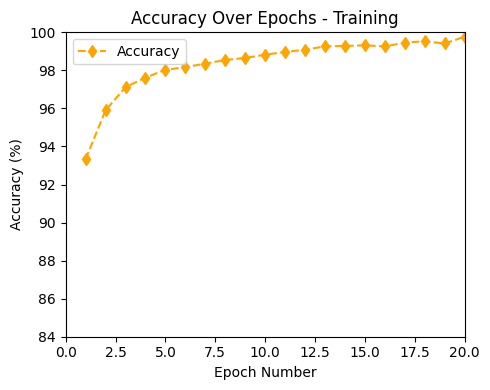

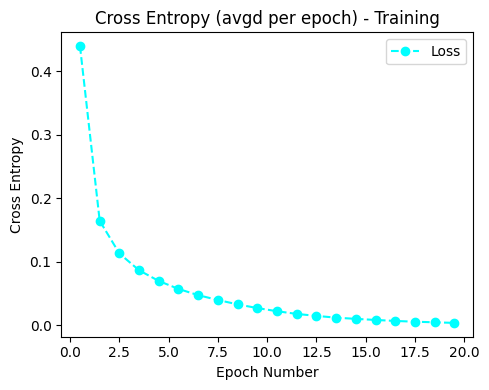

(None, None)

In [15]:
Analisis = Report(epoch_data, loss_data, Accurasy_data,  n_epochs =20)
Analisis.plot_accuracy(), Analisis.plot_training()

# Test Data

In [16]:
acurracy, x_fail, y_fail, yhat_fail = CheckAccuracy(test_dl, f, "Test Data")

hola 2
Accuracy of Test Data = 97.88; Received 9788/10000


# FAIL

In [17]:
x_fail[1].reshape(28,28).shape

torch.Size([28, 28])

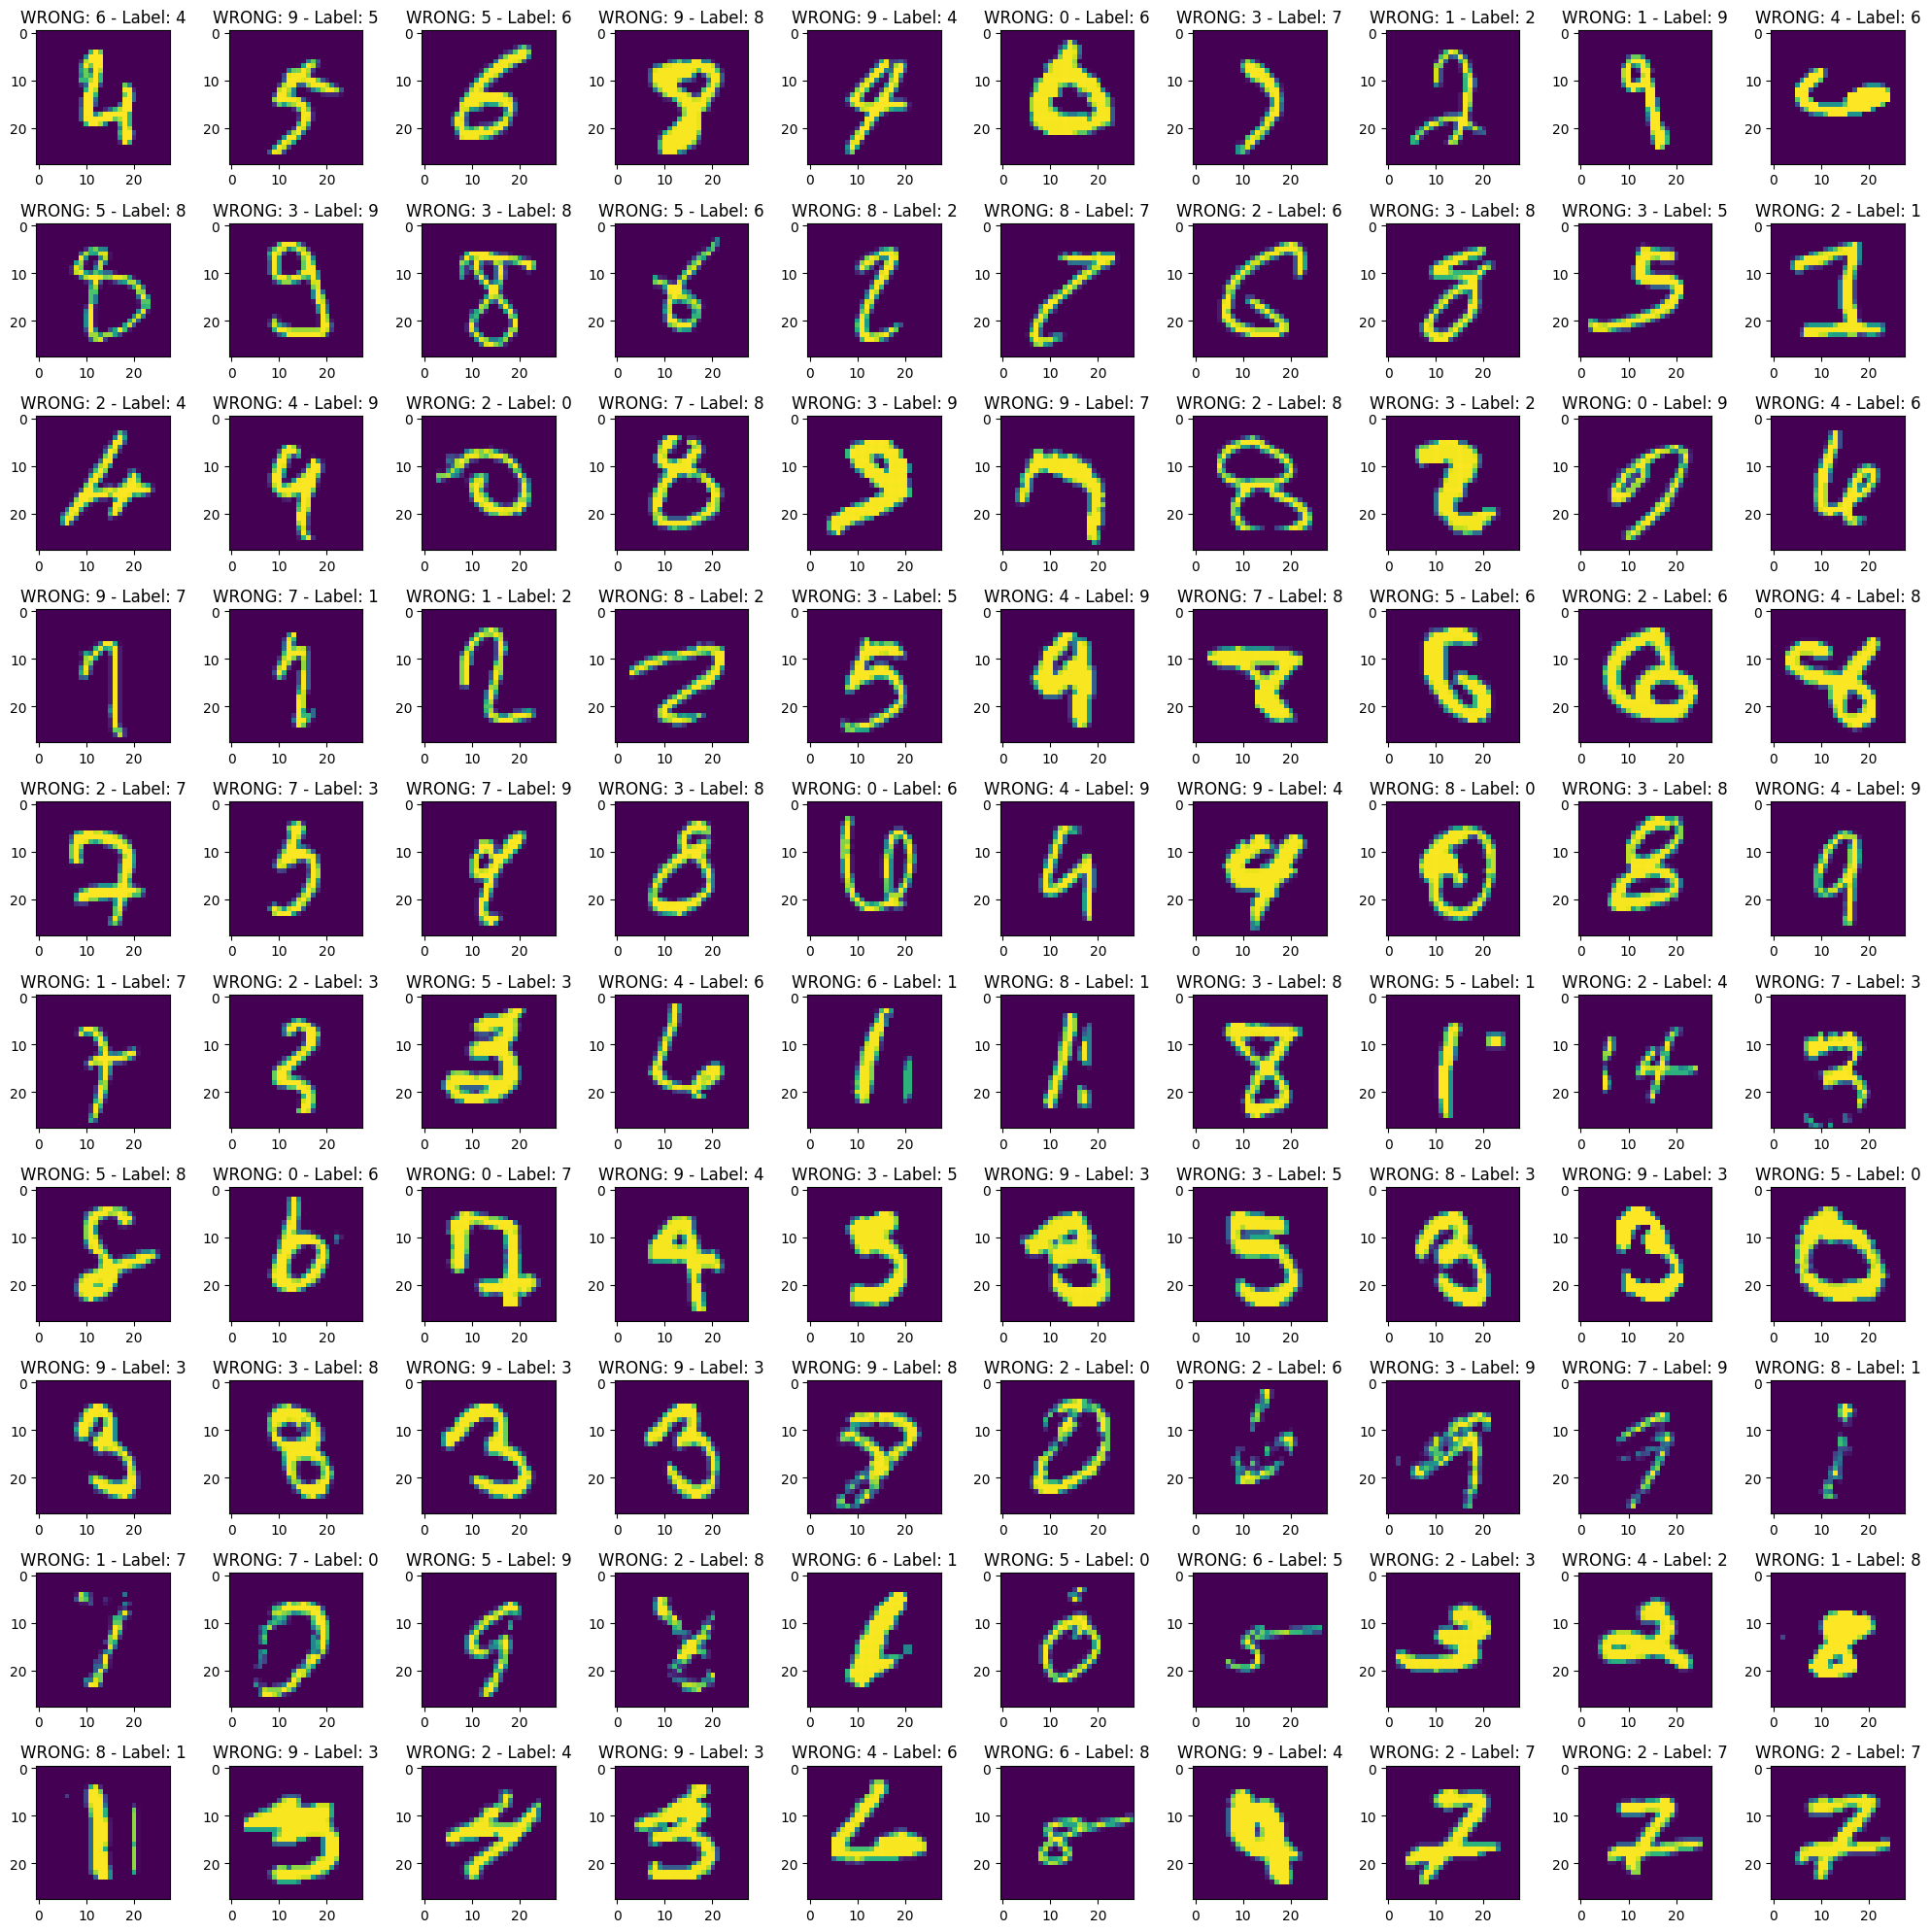

In [18]:
x_fail, y_fail, yhat_fail

fig, ax = plt.subplots(10,10,figsize=(20,20))
for i in range(100, 200):
    plt.subplot(10,10,i-99)
    plt.imshow(x_fail[i].reshape(28,28))
    plt.title(f'WRONG: {np.argmax(yhat_fail[i])} - Label: {np.argmax(y_fail[i])}')
fig.tight_layout()
plt.show()

In [19]:
xs, ys = test_ds[:2000]
yhats = f(xs).argmax(axis=1)
torch.max(yhats[0]),  torch.argmax(ys[0])

(tensor(7), tensor(7))

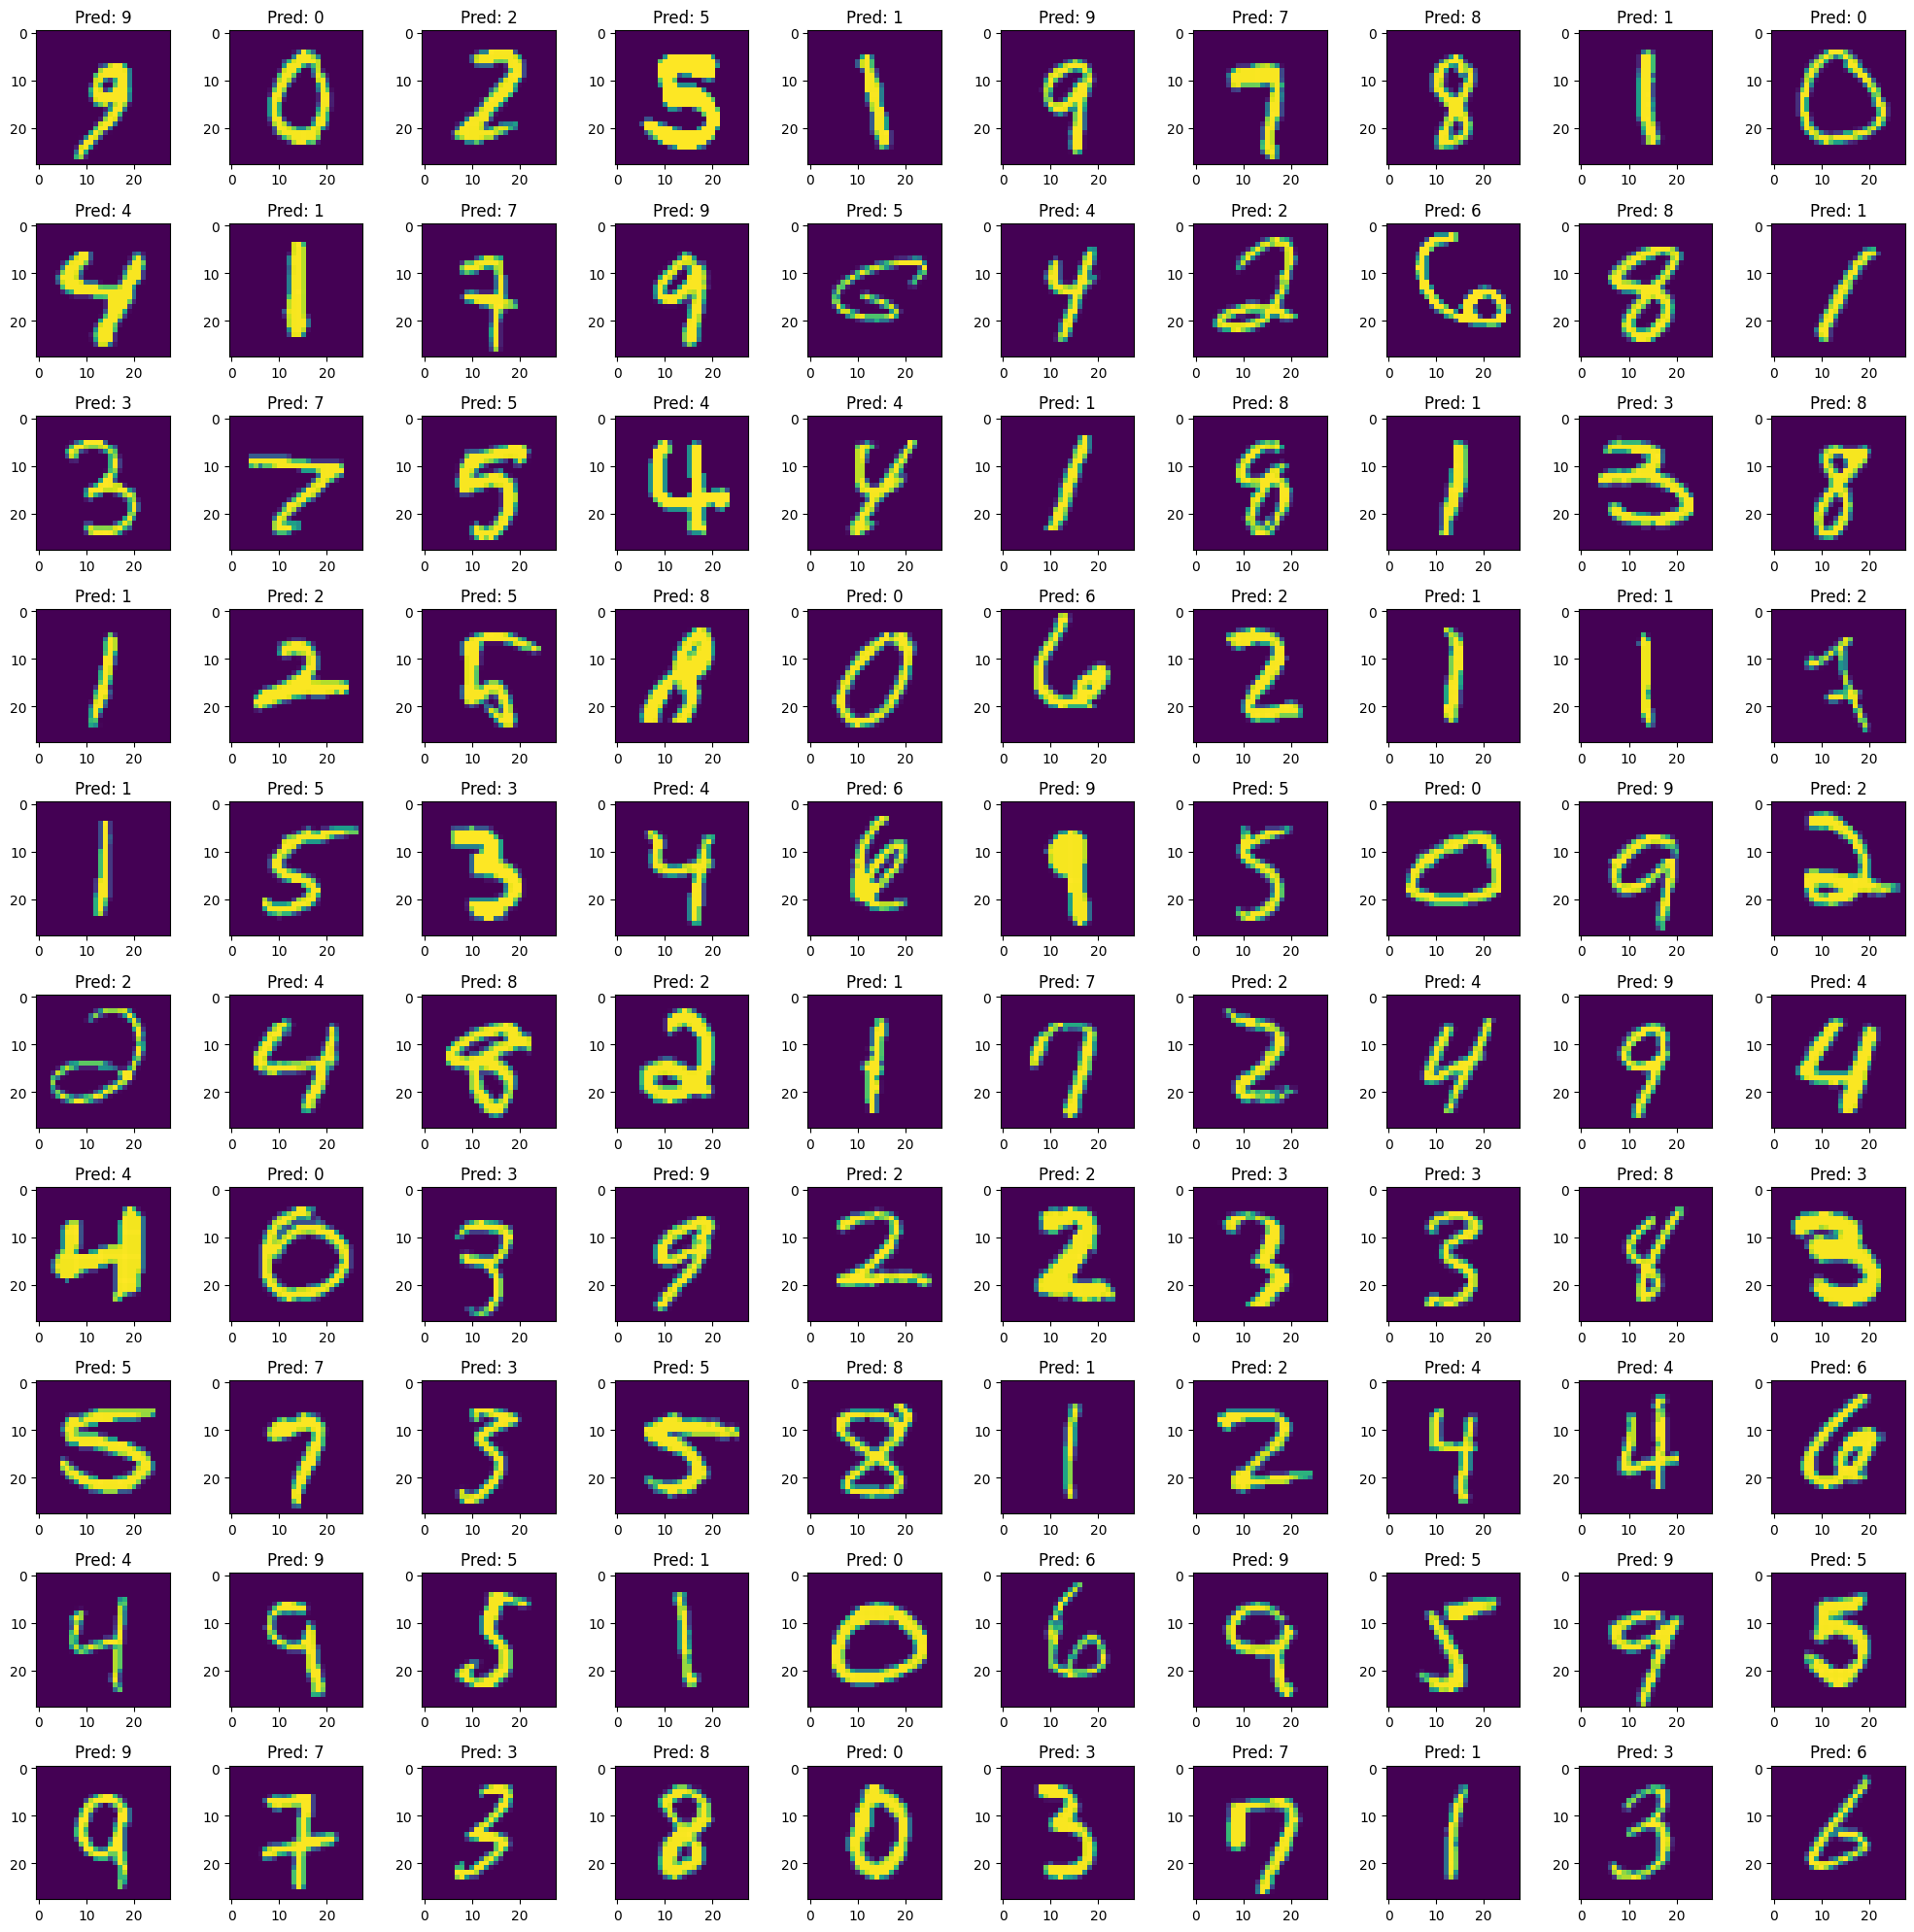

In [20]:
fig, ax = plt.subplots(10,10,figsize=(20,20))
for i in range(1000, 1100):
    plt.subplot(10,10,i+1-1000)
    plt.imshow(xs[i])
    if torch.max(yhats[0]) ==  torch.argmax(ys[0]):
        plt.imshow(xs[i])
        plt.title(f'Pred: {yhats[i]}')
    else:  
        plt.imshow(xs[i], cmap="RED")
        plt.title(f'WRONG Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()